# Self-Organising Maps

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines


# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [2]:
data.shape

(105, 6)

In [3]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [4]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
4,154860,99190,641
3,151490,94370,623
30,89664,748913,8352
99,14535,15175,1044
42,8550,6430,752
46,7300,5380,737
28,85300,732860,8592
64,23010,558340,24265
101,11000,16000,1455
29,87020,733300,8427


In [5]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
4,0.813216,0.041745,0.015939
3,0.795520,0.039716,0.015491
30,0.470853,0.315185,0.207673
99,0.076328,0.006387,0.025959
42,0.044899,0.002706,0.018699
46,0.038334,0.002264,0.018326
28,0.447936,0.308429,0.213641
64,0.120832,0.234981,0.603352
101,0.057764,0.006734,0.036179
29,0.456968,0.308615,0.209538


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

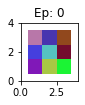

In [6]:
from our_som1A import SOM

# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [7]:
def predict(df, agri_som):
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [8]:
def arrange_data(agri_som):
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [66]:
def external_purity(df):
    classes = [str(i) for i in df.bmu_idx.tolist()]
    classes_uniq = set(classes)
    clusters = {i:{} for i in classes_uniq}
    data = [[str(i),j] for i,j in zip(df.bmu_idx.tolist(), df.Crop)]
    for i in classes_uniq:
        for j in data:
            exact= j[0]
            pred = j[1]
            if exact == i:
                if pred not in clusters[exact].keys():
                    clusters[exact][pred] = 1
                else:
                    clusters[exact][pred] += 1
    total_correct = 0
    total = len(data)
    for cluster in clusters.values():
        total_correct += max(cluster.values())


    print("accuracy: "+str(total_correct/total))



In [68]:
def visualize(joined_df, lr, lf,agri_som):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    ax.set_title("learning function: "+lf+", learning rate: "+str(lr))

    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()
    return joined_df

In [24]:
def run(lr, lf):
    agri_som = SOM(3,3,3)
    agri_som.train(trunc_data.values,
          num_epochs=100,
          init_learning_rate=lr,
          learning_rate_funtion=lf
          )
    joined_df = arrange_data(agri_som)
    df = visualize(joined_df, lr, lf, agri_som)
    external_purity(df)


<Figure size 432x288 with 0 Axes>

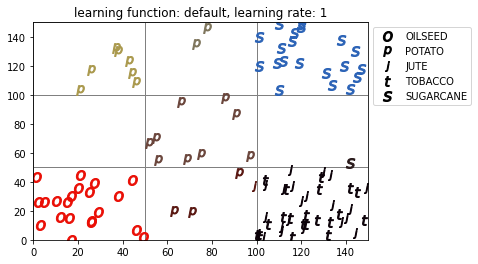

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

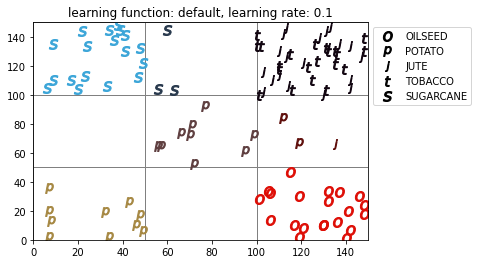

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

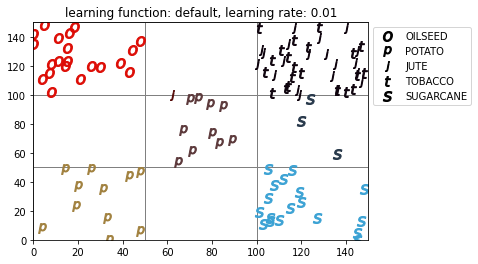

accuracy: 0.8095238095238095


<Figure size 432x288 with 0 Axes>

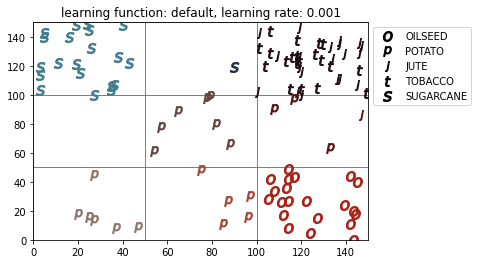

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

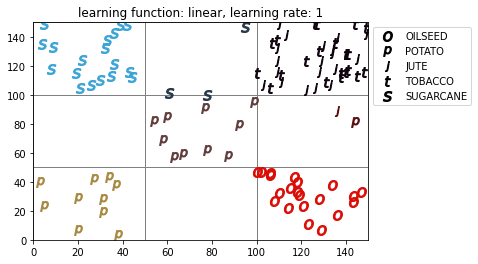

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

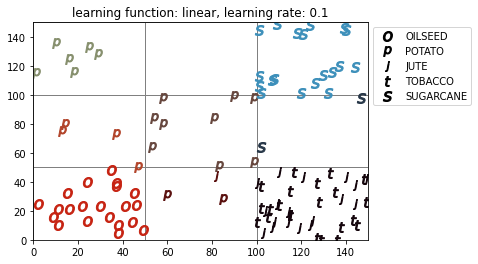

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

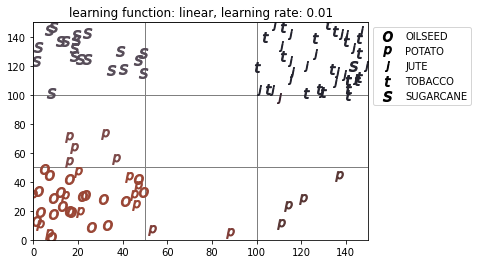

accuracy: 0.7047619047619048


<Figure size 432x288 with 0 Axes>

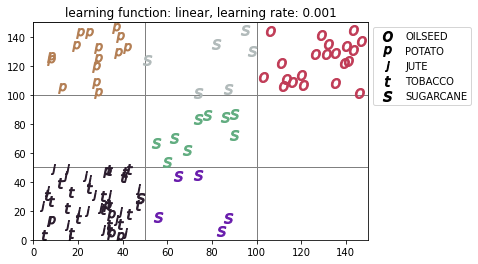

accuracy: 0.7333333333333333


<Figure size 432x288 with 0 Axes>

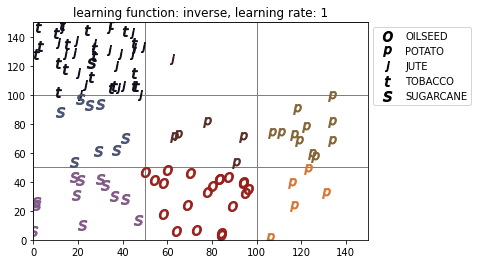

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

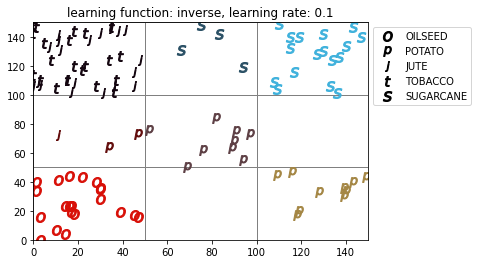

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

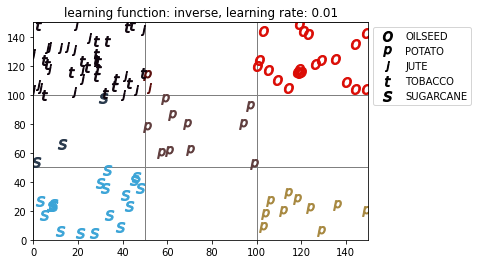

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

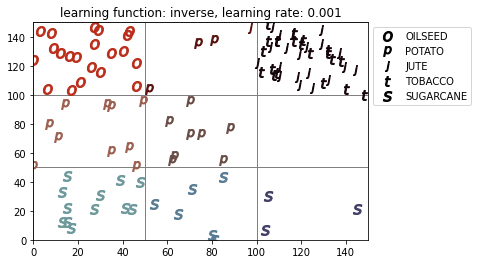

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

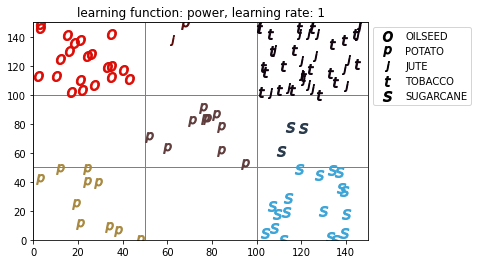

accuracy: 0.8


<Figure size 432x288 with 0 Axes>

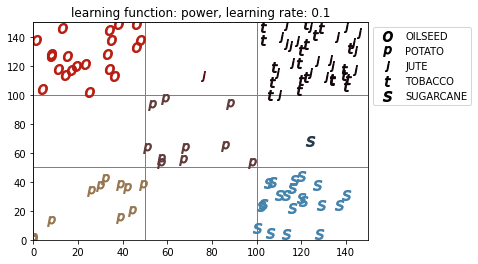

accuracy: 0.8095238095238095


<Figure size 432x288 with 0 Axes>

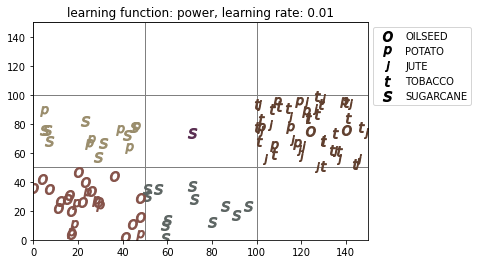

accuracy: 0.580952380952381


<Figure size 432x288 with 0 Axes>

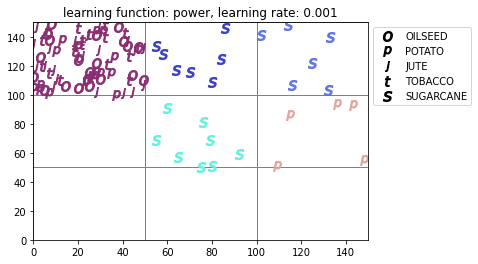

accuracy: 0.44761904761904764


In [70]:
for i in ["default", "linear", "inverse", "power"]:
    run(1, i)
    run(0.1, i)
    run(0.01, i)
    run(0.001, i)